In [1]:
from sqlalchemy import create_engine
import numpy as np
import pandas as pd
import pandas.io.sql as sqlio
import os
from dotenv import load_dotenv
import datetime as dt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import pickle as pkl
import json

In [2]:
RANDOM_STATE = 42

# Read Data

In [3]:
# Curry function to initialize postgres engine and return read_query function

def make_read_query(protocol=None, user=None, password=None, host=None, port=None, db=None):
    load_dotenv()
    
    protocol = protocol if protocol else 'postgresql+psycopg2'
    user = user if user else os.environ.get('POSTGRES_USER')
    password = password if password else os.environ.get('POSTGRES_PASSWORD')
    host = host if host else 'localhost'
    port = port if port else 5432
    db = db if db else os.environ.get('POSTGRES_DB')
    
    db_url = f'{protocol}://{user}:{password}@{host}:{port}/{db}'
    engine = create_engine(db_url)

    def read_query(query, verbose=True):
        if verbose:
            print(query, '\n')
            
        with engine.connect() as conn:
            df = sqlio.read_sql_query(query, conn)

        return df

    return read_query

In [4]:
read_query = make_read_query()

In [5]:
users_enriched = read_query("SELECT * FROM users_enriched")
users_enriched.head()

SELECT * FROM users_enriched 



,id,age,gender,country,city,traffic_source,n_orders,n_order_items,revenue,purchased_categories,...,first_purchase_date,last_purchase_date,active_days,inactive_days,avg_days_to_order,items_per_order,avg_order_value,segment,segment_churn_limit,churn_status
0,1,62,F,South Korea,Bucheon City,Search,1,3,159.99,"[Jeans, Active, Blazers & Jackets]",...,2022-07-19 11:29:28,2022-07-20 11:05:38,None,None,None,None,None,None,None,None
1,2,65,M,Brasil,Franca,Organic,1,1,22.00,[Underwear],...,2022-02-20 10:28:57,2022-02-20 10:28:57,None,None,None,None,None,None,None,None
2,3,16,M,United States,Hallandale Beach,Organic,4,5,402.20,"[Sleep & Lounge, Pants, Active, Jeans, Swim]",...,2023-03-10 07:14:45,2023-08-08 06:13:20,None,None,None,None,None,None,None,None
3,5,52,F,Brasil,União,Organic,1,3,65.65,"[Sweaters, Shorts, Skirts]",...,2022-10-20 06:35:35,2022-10-24 07:19:09,None,None,None,None,None,None,None,None
4,7,32,M,China,Jingdezhen,Search,1,1,84.21,[Suits & Sport Coats],...,2022-02-26 15:20:46,2022-02-26 15:20:46,None,None,None,None,None,None,None,None


In [6]:
users_enriched.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84011 entries, 0 to 84010
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    84011 non-null  int64         
 1   age                   84011 non-null  int64         
 2   gender                84011 non-null  object        
 3   country               84011 non-null  object        
 4   city                  84011 non-null  object        
 5   traffic_source        84011 non-null  object        
 6   n_orders              84011 non-null  int64         
 7   n_order_items         84011 non-null  int64         
 8   revenue               84011 non-null  float64       
 9   purchased_categories  84011 non-null  object        
 10  created_at            84011 non-null  datetime64[ns]
 11  first_purchase_date   69073 non-null  datetime64[ns]
 12  last_purchase_date    69073 non-null  datetime64[ns]
 13  active_days     

In [7]:
LIFETIME_COLS = ['active_days', 'inactive_days', 'avg_days_to_order', 'items_per_order', 'avg_order_value', 'segment', 'segment_churn_limit', 'churn_status']
users_enriched = users_enriched.drop(columns=LIFETIME_COLS)

In [8]:
users_enriched.describe()

,id,age,n_orders,n_order_items,revenue,created_at,first_purchase_date,last_purchase_date
count,84011.000000,84011.000000,84011.000000,84011.000000,84011.000000,84011,69073,69073
mean,50059.769102,41.059897,1.490591,2.163514,128.877396,2021-06-14 10:42:19.902129920,2022-07-16 08:15:15.045710592,2023-01-26 22:31:06.887598848
min,1.000000,12.000000,0.000000,0.000000,0.000000,2019-01-02 00:06:00,2019-01-06 02:25:41,2019-01-07 01:23:18
25%,25094.500000,26.000000,1.000000,1.000000,21.990000,2020-02-20 04:11:00,2021-09-13 00:20:14,2022-08-05 16:38:29
50%,50125.000000,41.000000,1.000000,2.000000,73.100000,2021-05-23 03:56:00,2022-10-20 18:26:08,2023-06-03 21:57:37
75%,75022.500000,56.000000,2.000000,3.000000,177.000000,2022-09-24 04:51:30,2023-07-30 10:50:57,2023-11-09 01:02:14
max,100000.000000,70.000000,40.000000,62.000000,3661.570000,2024-01-16 19:46:14.316147,2024-01-21 10:09:51.990337,2024-01-21 18:02:23.533893
std,28861.594335,17.047718,1.363647,2.216968,166.515183,NaN,NaN,NaN


# Data Preparation

In [9]:
def split_customers(users_enriched):
    inactive_users = users_enriched.loc[users_enriched.n_orders==0]
    one_off_customers = users_enriched.loc[users_enriched.n_orders==1]
    repeat_purchasers = users_enriched.loc[users_enriched.n_orders>1]
    return repeat_purchasers, one_off_customers, inactive_users

In [10]:
def make_lifetime_features(repeat_purchasers, now):
    df_lifetime = repeat_purchasers.copy()
    df_lifetime['active_days'] = (df_lifetime.last_purchase_date - df_lifetime.first_purchase_date).dt.days + 1
    df_lifetime['inactive_days'] = (now - df_lifetime.last_purchase_date).dt.days
    df_lifetime['avg_days_to_order'] = df_lifetime['active_days'] / (df_lifetime['n_orders'] - 1)
    df_lifetime['items_per_order'] = df_lifetime['n_order_items'] / df_lifetime['n_orders']
    df_lifetime['avg_order_value'] = df_lifetime['revenue'] / df_lifetime['n_orders']
    df_lifetime = df_lifetime[['active_days', 'inactive_days', 'avg_days_to_order', 'items_per_order', 'avg_order_value']]
    return df_lifetime

In [11]:
def plot_histograms(df, columns=None, width=14, height=7, bins=20):
    columns = df.columns if columns is None else columns
    n_subplots = len(columns)
    n_subplot_rows = round(np.sqrt(n_subplots))
    n_subplot_cols = n_subplots / n_subplot_rows

    n_subplot_cols = int(n_subplot_cols) + 1 if n_subplot_cols % 1 > 0 else int(n_subplot_cols)
    
    fig, axs = plt.subplots(n_subplot_rows, n_subplot_cols)
    fig.set_figwidth(14)
    fig.set_figheight(7)

    for i, col in enumerate(columns):
        ax_row = i // n_subplot_cols
        ax_col = i % n_subplot_cols
        ax = axs[ax_row,ax_col]
        ax.set_title(col)
        df[col].hist(bins=bins, ax=ax)

In [12]:
repeat_purchasers, one_off_customers, inactive_users = split_customers(users_enriched)
print('Repeat Purchasers:', repeat_purchasers.shape[0], 
      'One-Off Customers', one_off_customers.shape[0], 
      'Inactive Users', inactive_users.shape[0])

Repeat Purchasers: 30731 One-Off Customers 38342 Inactive Users 14938


In [13]:
now = users_enriched.last_purchase_date.max()
now

Timestamp('2024-01-21 18:02:23.533893')

In [14]:
df_lifetime = make_lifetime_features(repeat_purchasers, now)

In [15]:
df_lifetime.describe()

,active_days,inactive_days,avg_days_to_order,items_per_order,avg_order_value
count,30731.000000,30731.000000,30731.000000,30731.000000,30731.000000
mean,437.179428,245.247307,277.151107,1.452578,86.637559
std,381.982823,270.456375,268.224506,0.512634,59.879672
min,1.000000,0.000000,0.333333,1.000000,4.470000
25%,120.000000,47.000000,84.000000,1.000000,46.740000
50%,334.000000,146.000000,198.000000,1.333333,72.645000
75%,674.000000,354.000000,380.000000,1.666667,109.145833
max,1785.000000,1802.000000,1745.000000,4.000000,869.485000


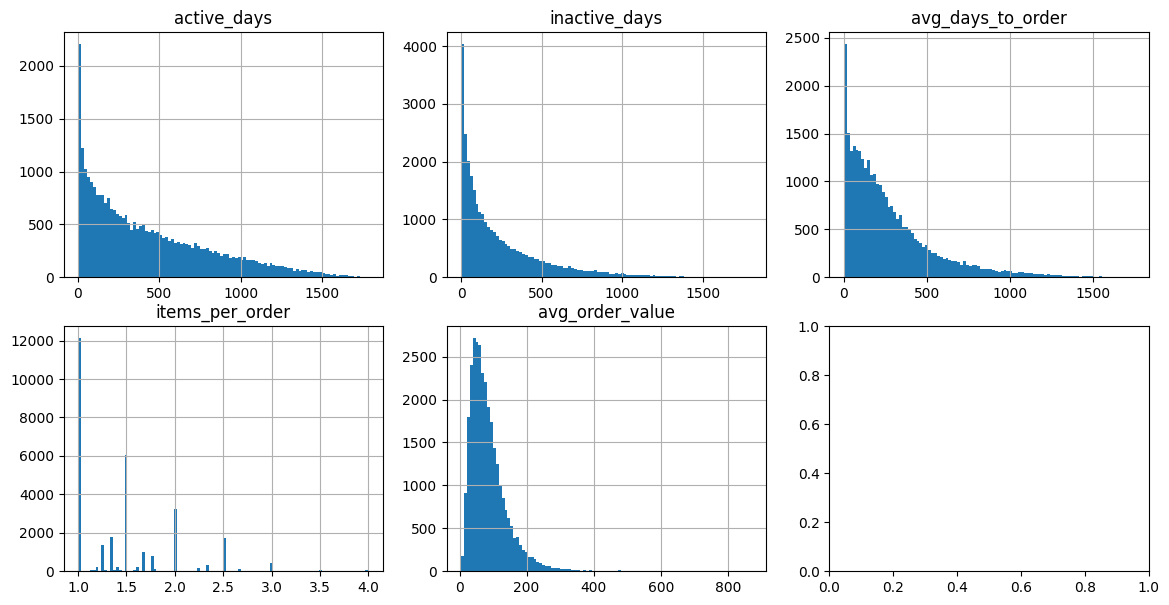

In [16]:
plot_histograms(df_lifetime, bins=100)

<Axes: >

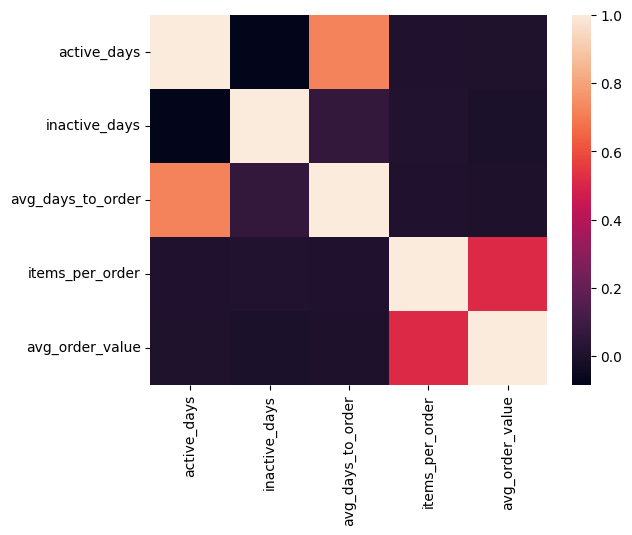

In [17]:
sns.heatmap(df_lifetime.corr())

# Clustering Repeat Purchasers

In [18]:
def model_results_to_df(results, explode_hyperparams=True):
    df = pd.DataFrame(results)
    if explode_hyperparams:
        df_hyperparams = pd.DataFrame(df['hyperparams'].tolist())
        df = pd.concat([df, df_hyperparams], axis=1)\
                .drop(columns='hyperparams')
    return df

def search_clustering_hyperparams(model_type, hyperparams, X, random_state=None, verbose=True, explode_hyperparams=True):
    results = []        
    for hyperparams_iter in hyperparams:
        if random_state:
            hyperparams_iter['random_state'] = random_state
        model = model_type(**hyperparams_iter)
        y = model.fit_predict(X)
        silhouette = silhouette_score(X, y)
        inertia = model.inertia_ if model_type == KMeans else None
        
        results_dict = { 
            'hyperparams': hyperparams_iter, 
            'model': model, 
            'silhouette_score': silhouette,
            'inertia': inertia if inertia else cost
        }
        
        results.append(results_dict)

        if verbose:
            print(hyperparams_iter, f'Silhouette Score: {silhouette}', f'Inertia: {inertia}', sep=' | ')

    df_results = model_results_to_df(results, explode_hyperparams=True)
    
    return df_results

In [19]:
def plot_clusters(X, y, figwidth=15, figheight=10, bins=20):
    X = pd.DataFrame(X) if type(X) != pd.DataFrame else X
    labels = np.unique(y)

    fig, axs = plt.subplots(len(labels), len(X.columns))
    fig.set_figwidth(figwidth)
    fig.set_figheight(figheight)
    fig.suptitle('Cluster Feature Histograms')
    fig.subplots_adjust(wspace=0.3, hspace=0.3)

    col_mins = {}
    col_maxs = {}
    col_means = {}
    for col in X.columns:
        col_mins[col] = X[col].min()
        col_maxs[col] = X[col].max()
        col_means[col] = X[col].mean()

    for i, label in enumerate(labels):
        X_cluster = X.loc[y==label]
        for j, col in enumerate(X.columns):        
            ax = axs[i,j]
            ax.set_xlim(col_mins[col], col_maxs[col])
            if j == 0:
                ax.set_ylabel(label)
            if i == len(labels) - 1:
                ax.set_xlabel(col)
            
            X_cluster[col].hist(ax=ax, bins=bins)
            cluster_col_mean = X_cluster[col].mean()
            ymax = pd.cut(X_cluster[col], bins).value_counts().max()
            ax.vlines(cluster_col_mean, ymin=0, ymax=ymax, color='tab:orange', label='Cluster Mean')
            ax.vlines(col_means[col], ymin=0, ymax=ymax, color='tab:red', label='Sample Mean')

    handles, labels = axs[0,0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')

In [20]:
X_cols = ['active_days', 'avg_days_to_order', 'avg_order_value']
X_raw = df_lifetime[X_cols]

In [21]:
scaler = StandardScaler()
X = scaler.fit_transform(X_raw)

In [22]:
hyperparams = [{'n_clusters': i} for i in range(2, 11)]
results = search_clustering_hyperparams(KMeans, hyperparams, X, random_state=RANDOM_STATE)

{'n_clusters': 2, 'random_state': 42} | Silhouette Score: 0.4238823797582957 | Inertia: 55629.05141463291
{'n_clusters': 3, 'random_state': 42} | Silhouette Score: 0.3465476674541914 | Inertia: 46646.475332710936
{'n_clusters': 4, 'random_state': 42} | Silhouette Score: 0.3825803241441824 | Inertia: 32791.797609983565
{'n_clusters': 5, 'random_state': 42} | Silhouette Score: 0.343662869474977 | Inertia: 28073.25319844619
{'n_clusters': 6, 'random_state': 42} | Silhouette Score: 0.3498438522053427 | Inertia: 23621.65989877087
{'n_clusters': 7, 'random_state': 42} | Silhouette Score: 0.33717109560628356 | Inertia: 21099.916532709387
{'n_clusters': 8, 'random_state': 42} | Silhouette Score: 0.34136287826472517 | Inertia: 18671.429131833713
{'n_clusters': 9, 'random_state': 42} | Silhouette Score: 0.3266250554585075 | Inertia: 17229.523489341424
{'n_clusters': 10, 'random_state': 42} | Silhouette Score: 0.32354074410989836 | Inertia: 15542.951965331074


<Axes: title={'center': 'Silhouette Score'}, xlabel='n_clusters'>

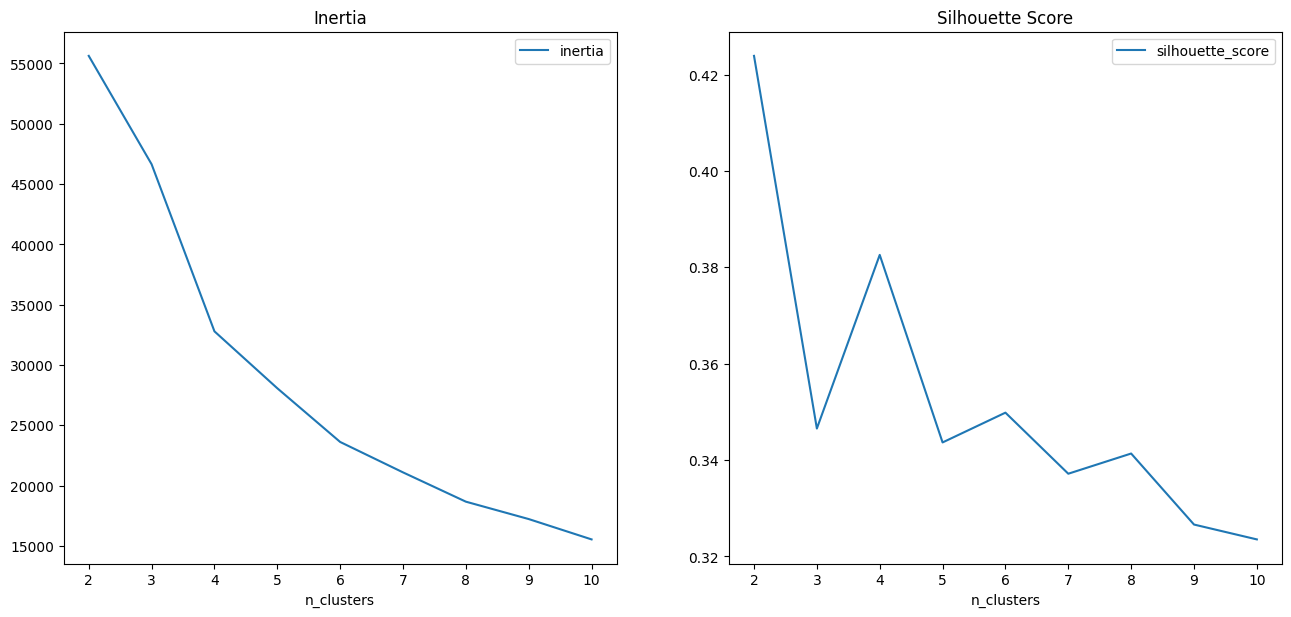

In [23]:
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(14)
fig.set_figheight(7)
plt.tight_layout(pad=5)

axs[0].set_title('Inertia')
results.plot(x='n_clusters', y='inertia', ax=axs[0])

axs[1].set_title('Silhouette Score')
results.plot(x='n_clusters', y='silhouette_score', ax=axs[1])

In [24]:
model = results.loc[results.n_clusters==4, 'model'].iloc[0]
df_lifetime_cluster = df_lifetime.copy()
df_lifetime_cluster['cluster'] = model.labels_

In [25]:
cluster_centers = scaler.inverse_transform(model.cluster_centers_)
cluster_centers = pd.DataFrame(cluster_centers, columns=X_cols)
cluster_centers

,active_days,avg_days_to_order,avg_order_value
0,746.718670,367.806110,74.510632
1,300.442550,211.559711,203.843981
2,169.058704,117.223168,67.141078
3,1034.051034,895.018346,81.858053


In [26]:
df_lifetime_cluster['cluster'].value_counts()

cluster
2    15204
0     8958
1     3586
3     2983
Name: count, dtype: int64

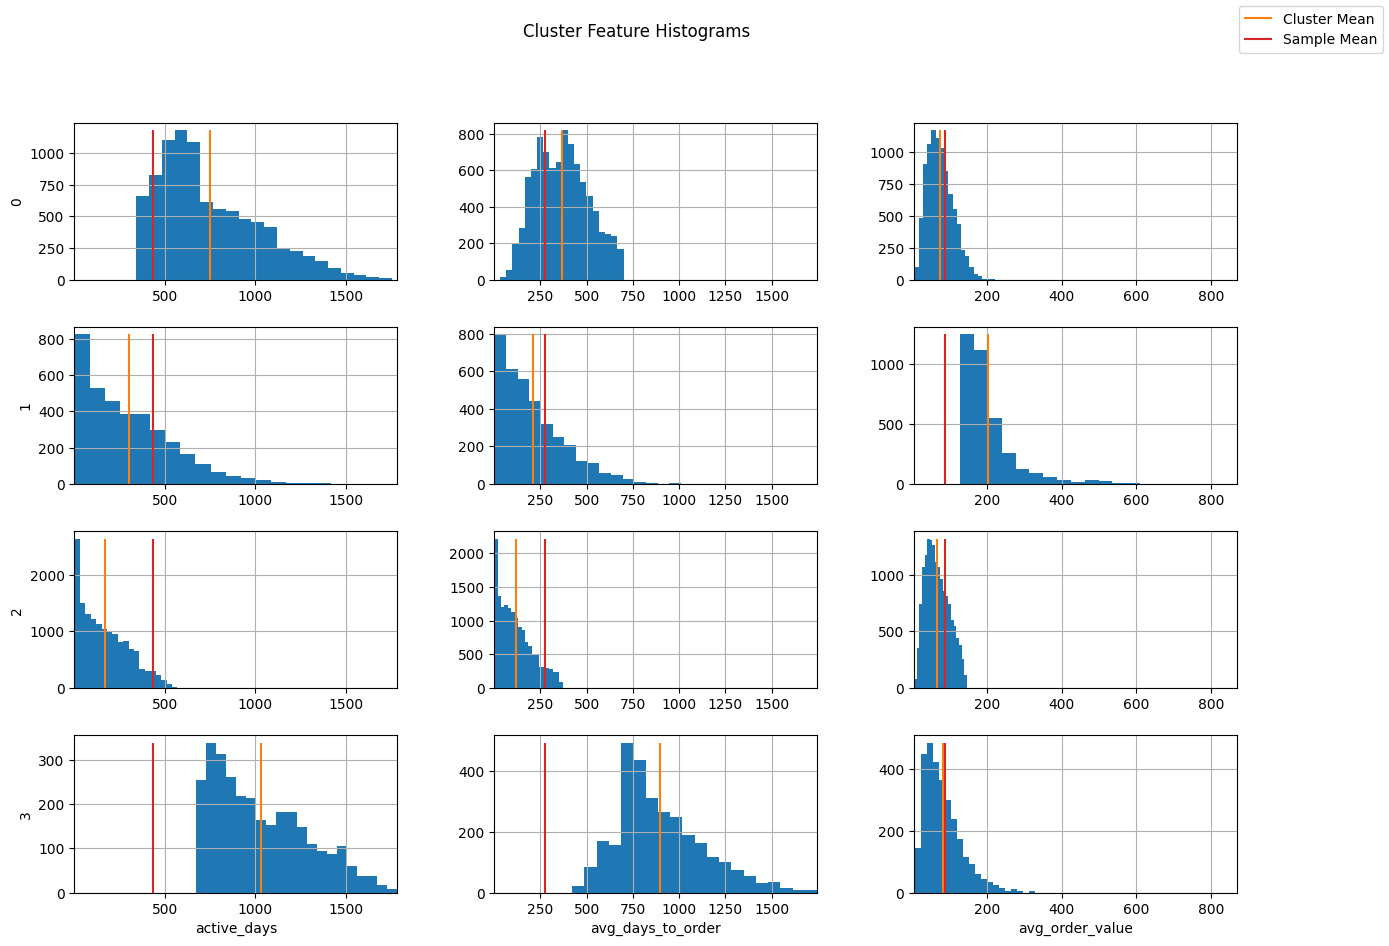

In [27]:
plot_clusters(X_raw, model.labels_)

In [28]:
print('Cluster Mean / Sample Mean:', df_lifetime_cluster.groupby('cluster').mean() / df_lifetime_cluster.drop(columns='cluster').mean(), sep='\n')
print('\n'+80*'-'+'\n', 'Cluster Mean:', df_lifetime_cluster.groupby('cluster').mean(), sep='\n')
print('\n'+80*'-'+'\n', '\nCluster Std:', df_lifetime_cluster.groupby('cluster').std(), sep='\n')
print('\n'+80*'-'+'\n', '\nCluster Min:', df_lifetime_cluster.groupby('cluster').min(), sep='\n')
print('\n'+80*'-'+'\n', '\nCluster Max:', df_lifetime_cluster.groupby('cluster').max(), sep='\n')

Cluster Mean / Sample Mean:
         active_days  inactive_days  avg_days_to_order  items_per_order  \
cluster                                                                   
0           1.711357       0.972498           1.329040         0.965121   
1           0.685986       1.099557           0.762478         1.355682   
2           0.387428       1.005152           0.423540         0.936461   
3           2.363478       0.936649           3.235573         1.001010   

         avg_order_value  
cluster                   
0               0.860198  
1               2.350663  
2               0.774487  
3               0.945549  

--------------------------------------------------------------------------------

Cluster Mean:
         active_days  inactive_days  avg_days_to_order  items_per_order  \
cluster                                                                   
0         748.170127     238.502568         368.344922         1.401914   
1         299.899052     269.663413  

In [29]:
segment_map = {
    0: 'Loyals',
    1: 'High AOV',
    2: 'Others',
    3: 'Loyals with Low Frequency'
}

In [30]:
df_lifetime_cluster['cluster'] = df_lifetime_cluster['cluster'].map(segment_map) 

In [31]:
df_lifetime_cluster

,active_days,inactive_days,avg_days_to_order,items_per_order,avg_order_value,cluster
2,151,166,50.333333,1.25,100.5500,Others
6,1262,76,1262.000000,3.00,271.7450,Loyals with Low Frequency
8,150,10,150.000000,1.00,88.6750,Others
9,92,196,30.666667,1.50,81.3875,Others
10,1,5,1.000000,1.00,63.9750,Others
...,...,...,...,...,...,...
83993,274,294,274.000000,1.00,20.5400,Others
83997,530,149,176.666667,1.25,126.4750,Loyals
84007,956,312,956.000000,2.00,61.9350,Loyals with Low Frequency
84009,348,183,116.000000,1.00,35.4975,Others


In [32]:
df_lifetime_cluster.cluster.value_counts()

cluster
Others                       15204
Loyals                        8958
High AOV                      3586
Loyals with Low Frequency     2983
Name: count, dtype: int64

# Flag Potentially Churned Customers

In [34]:
def add_churn_status(df_lifetime_cluster, percentile=0.9):
    cluster_churn_limits = df_lifetime_cluster.groupby('cluster')\
                                              .avg_days_to_order.quantile(percentile)\
                                              .to_frame('churn_limit')
    df_lifetime_cluster = df_lifetime_cluster.join(cluster_churn_limits, on='cluster')
    churn_idx = df_lifetime_cluster['inactive_days'] > df_lifetime_cluster['churn_limit']
    df_lifetime_cluster['churn_status'] = 'Active'
    df_lifetime_cluster.loc[churn_idx, 'churn_status'] = 'Churn Likely'
    return df_lifetime_cluster

In [35]:
df_lifetime_flagged = add_churn_status(df_lifetime_cluster)

In [36]:
df_lifetime_flagged.groupby('cluster')[['churn_limit']].first()

,churn_limit
cluster,
High AOV,459.0
Loyals,568.0
Loyals with Low Frequency,1231.0
Others,257.0


In [37]:
df_lifetime_flagged.groupby('cluster')['churn_status'].value_counts()

cluster                    churn_status
High AOV                   Active           2854
                           Churn Likely      732
Loyals                     Active           7987
                           Churn Likely      971
Loyals with Low Frequency  Active           2983
Others                     Active          10209
                           Churn Likely     4995
Name: count, dtype: int64

# Concat Data

In [38]:
def concat_lifetime_cols(repeat_purchasers, df_lifetime_flagged):
    return  pd.concat([repeat_purchasers, df_lifetime_flagged], axis=1)

In [39]:
def concat_customers(repeat_purchasers_clustered, one_off_customers, inactive_users):
    repeat_purchasers_clustered = repeat_purchasers_clustered.rename(columns={'cluster': 'segment',
                                                                              'churn_limit': 'segment_churn_limit'})
    one_off_customers, inactive_users = one_off_customers.copy(), inactive_users.copy()
    one_off_customers['segment'] = 'One-Off Customers'
    inactive_users['segment'] = 'Never Ordered'
    customers_segmented = pd.concat([repeat_purchasers_clustered, one_off_customers, inactive_users])\
                            .sort_values('created_at')
    return customers_segmented

In [40]:
repeat_purchasers_clustered = concat_lifetime_cols(repeat_purchasers, df_lifetime_flagged)

one_off_customers_lifetime = make_lifetime_features(one_off_customers, now)
one_off_customers_ = one_off_customers.join(one_off_customers_lifetime)
one_off_customers_.loc[one_off_customers_.avg_days_to_order==np.inf, 'avg_days_to_order'] = None

customers_segmented = concat_customers(repeat_purchasers_clustered, one_off_customers_, inactive_users)

In [42]:
customers_segmented.groupby(['segment'])['id'].count()

segment
High AOV                      3586
Loyals                        8958
Loyals with Low Frequency     2983
Never Ordered                14938
One-Off Customers            38342
Others                       15204
Name: id, dtype: int64

In [44]:
customers_segmented.groupby(['segment', 'churn_status'])['id'].count()

segment                    churn_status
High AOV                   Active           2854
                           Churn Likely      732
Loyals                     Active           7987
                           Churn Likely      971
Loyals with Low Frequency  Active           2983
Others                     Active          10209
                           Churn Likely     4995
Name: id, dtype: int64

# Save Pipeline 

In [45]:
pipe = Pipeline([('scaler', scaler), ('kmeans', model)])

In [46]:
# with open('../models/cust_segment_pipe.pkl', 'wb') as f:
#     pkl.dump(pipe, f)

In [47]:
with open('../models/cust_segment_pipe.pkl', 'rb') as f:
    pipe_loaded = pkl.load(f)

In [48]:
y = pipe_loaded.predict(X_raw)
(y == model.labels_).all()

np.True_

In [49]:
with open('../models/cust_segment_map.json', 'w') as f:
    json.dump(segment_map, f)

In [50]:
with open('../models/cust_segment_map.json', 'r') as f:
    segment_map_ = json.load(f)

In [51]:
segment_map_

{'0': 'Loyals',
 '1': 'High AOV',
 '2': 'Others',
 '3': 'Loyals with Low Frequency'}